Copyright 2021 Abbrivia GmbH https://www.abbrivia.com CC-BY (By Attribution) 4.0 https://creativecommons.org/licenses/by/4.0/legalcode
Reuse our work freely

All visualizations, and code produced in this notebook are completely open access under the Creative Commons BY license. You have the permission to use, distribute, and reproduce these in any medium, provided the source and authors are credited.

The data produced by third parties and made available by "Our World in Data" is subject to the license terms from the original third-party authors. Check the license of any third-party data before use and redistribution on 'https://ourworldindata.org/coronavirus' site (see below).

# This notebook shows a noteworthy relationship between Vaccinations and Excess Mortality in OWID Dataset 

The same clusters appear on the scatter plot of Excess Mortality vs Vaccinations and on the geographical map.

# Getting the Data

See the defintions and further discussion on the used dataset at the "Our World in Data" site  https://ourworldindata.org/covid-vaccinations

The data is taken specifically from https://covid.ourworldindata.org/data/owid-covid-data.xlsx file

Hannah Ritchie, Edouard Mathieu, Lucas Rodés-Guirao, Cameron Appel, Charlie Giattino, Esteban Ortiz-Ospina, Joe Hasell, Bobbie Macdonald, Diana Beltekian and Max Roser (2020) - "Coronavirus Pandemic (COVID-19)". Published online at OurWorldInData.org. Retrieved from: 'https://ourworldindata.org/coronavirus' [Online Resource]

We use Excel file because it contains the data format information in itself. If you want to run this more often consider manually downloading the data and sourcing it locally as shown in the next line (commented out).

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

In [2]:
d=pd.read_excel('https://covid.ourworldindata.org/data/owid-covid-data.xlsx')

Let's only leave the rows that have both Vaccinations and Excess Mortality data.

In [3]:
df=d[(~d['excess_mortality_cumulative_per_million'].isnull()) & (~d['total_vaccinations_per_hundred'].isnull())]
del d

And we take the latest values for each country.

In [4]:
df_latest=df.loc[df.groupby(['iso_code'])['total_vaccinations_per_hundred'].idxmax()]
del df

We have noted that the countries can be split into two groups by the 'excess_mortality_cumulative_per_million' / 'total_vaccinations_per_hundred'] ratio (empirical value 25).

In [5]:
df_latest['excess_mortality_vaccination_cluster']=np.where(df_latest['excess_mortality_cumulative_per_million']/df_latest['total_vaccinations_per_hundred']>25,'1','0')

# The Charts of Vaccinations and Excess Mortality per Country as a Scatter and Choropleth 
It is noteworthy that countries split in 'Higher Slope'-1,'Lower Slope'-0 clusters on the scatter chart also appear on a map as mostly contigious clusters in Eurasia AND both Americas.

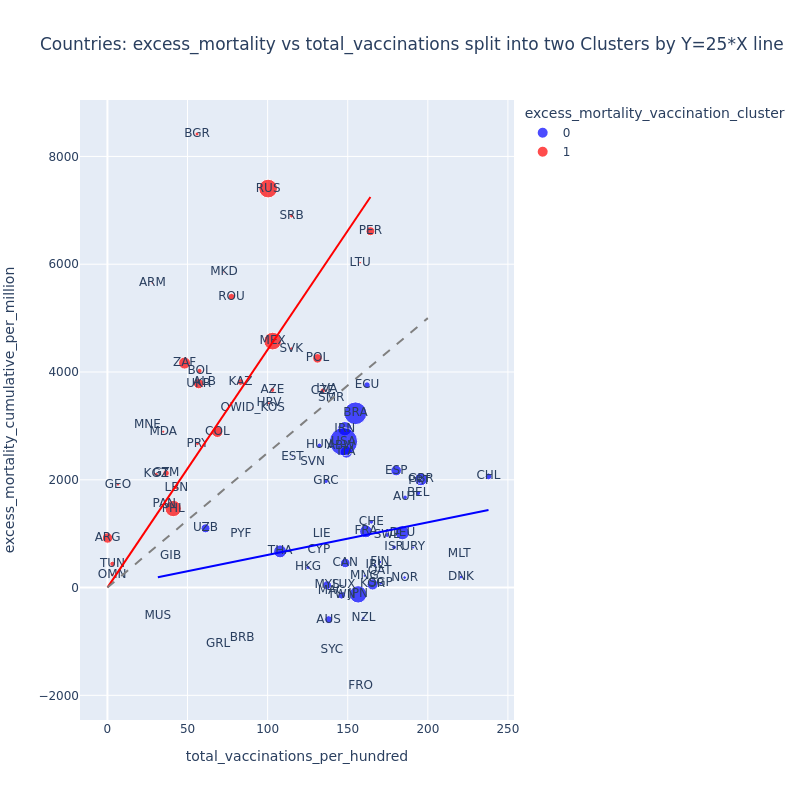

In [6]:
fig = px.scatter(df_latest,    
              x='total_vaccinations_per_hundred',
              y='excess_mortality_cumulative_per_million',
              color='excess_mortality_vaccination_cluster',
              color_discrete_sequence=['blue','red'],
              size='population',
              trendline='ols',
              trendline_options=dict(add_constant=False),   
              text='iso_code',
              width=800,
              height=800,
              title='Countries: excess_mortality vs total_vaccinations split into two Clusters by Y=25*X line'
             )
fig.add_trace(
    go.Scatter(
        x=[0, 200],
        y=[0, 200*25],
        mode="lines",
        line=go.scatter.Line(color="gray",dash='dash'),
        showlegend=False)
)
fig.show('png')

In [7]:
results = px.get_trendline_results(fig)
for cluster in [1,0]:
    print('cluster=',cluster,results.px_fit_results[cluster].summary())

cluster= 1                                  OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.802
Model:                            OLS   Adj. R-squared (uncentered):              0.797
Method:                 Least Squares   F-statistic:                              138.0
Date:                Sat, 29 Jan 2022   Prob (F-statistic):                    1.62e-13
Time:                        21:38:17   Log-Likelihood:                         -313.21
No. Observations:                  35   AIC:                                      628.4
Df Residuals:                      34   BIC:                                      630.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

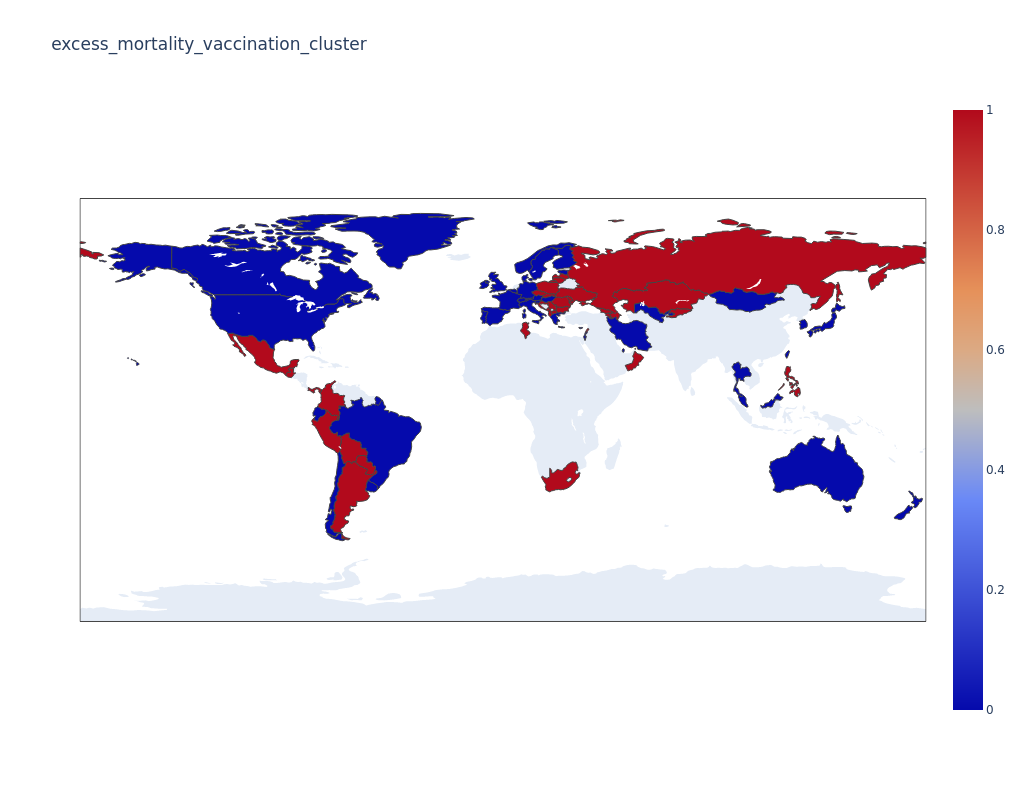

In [8]:
for metric in ['excess_mortality_vaccination_cluster',]:
    fig = go.Figure(data=go.Choropleth(
        locationmode = 'ISO-3',
        locations = df_latest['iso_code'],
        z = df_latest[metric],
        autocolorscale=False,
        #showscale=False
    ))
    fig.update_layout(
        width=1024,
        height=800,
        title_text=metric,
        geo=dict(
            showcoastlines=False,
        ),
        )
    fig.show('png')

# What variables could otherwise explain the clusters?
We build a Decision Tree Classifier and look at the importance of the variables

life_expectancy = 0.55
median_age = 0.16
cardiovasc_death_rate = 0.10
aged_65_older = 0.09
female_smokers = 0.05
stringency_index = 0.05
population_density = 0.00
aged_70_older = 0.00
gdp_per_capita = 0.00
extreme_poverty = 0.00
diabetes_prevalence = 0.00
male_smokers = 0.00
handwashing_facilities = 0.00
hospital_beds_per_thousand = 0.00
human_development_index = 0.00


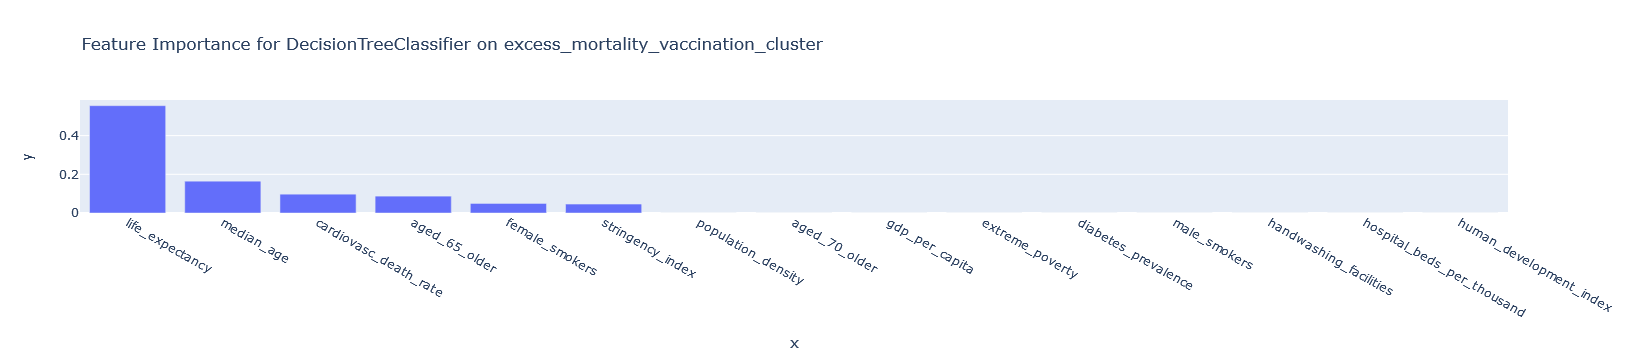

In [9]:
# decision tree for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeClassifier
variables=['stringency_index',
       'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index',]
X = df_latest[variables].fillna(df_latest.mean()).values
y = df_latest['excess_mortality_vaccination_cluster'].values
model = DecisionTreeClassifier(random_state=42)
model.fit(X, y)
features_dict=dict(zip(variables, model.feature_importances_))
#sorted by value descending
sorted_features_dict=dict(sorted(features_dict.items(), key=lambda item: -item[1]))
for k, v in sorted_features_dict.items():
    print(f'{k} = {v:1.2f}')
fig=px.bar(x=sorted_features_dict.keys(), 
           y=sorted_features_dict.values(),
           title='Feature Importance for DecisionTreeClassifier on excess_mortality_vaccination_cluster'
          )
fig.show()

# Explorative Choropleth Charts of All Variables For Reference

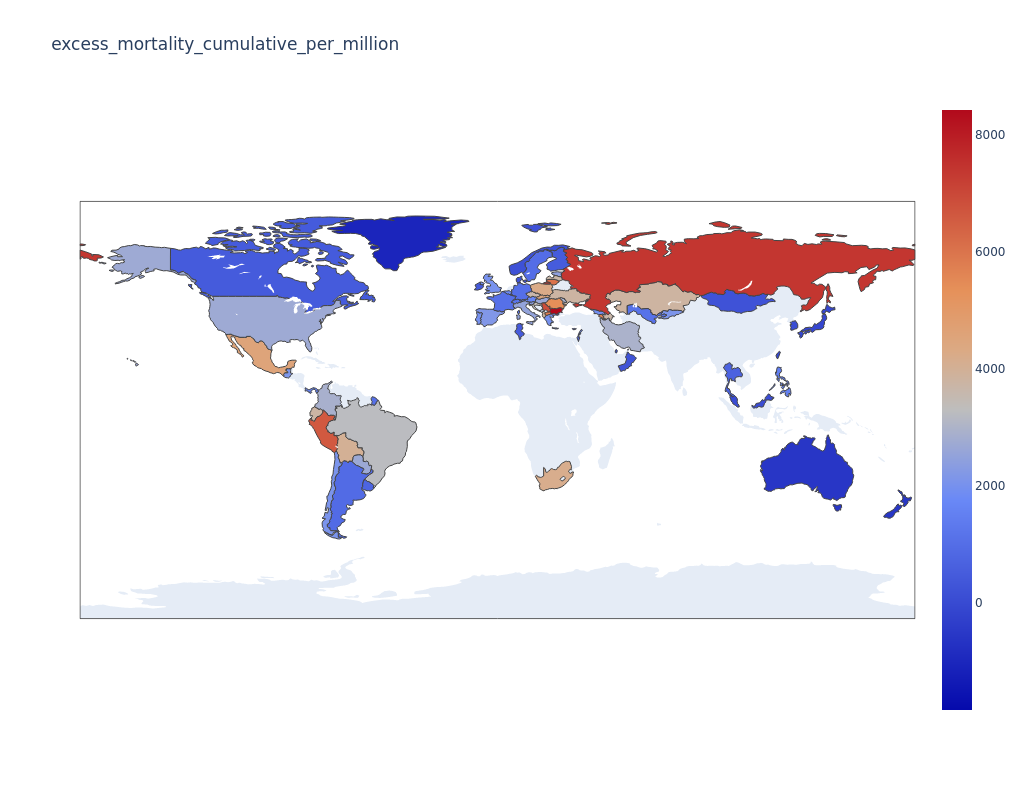

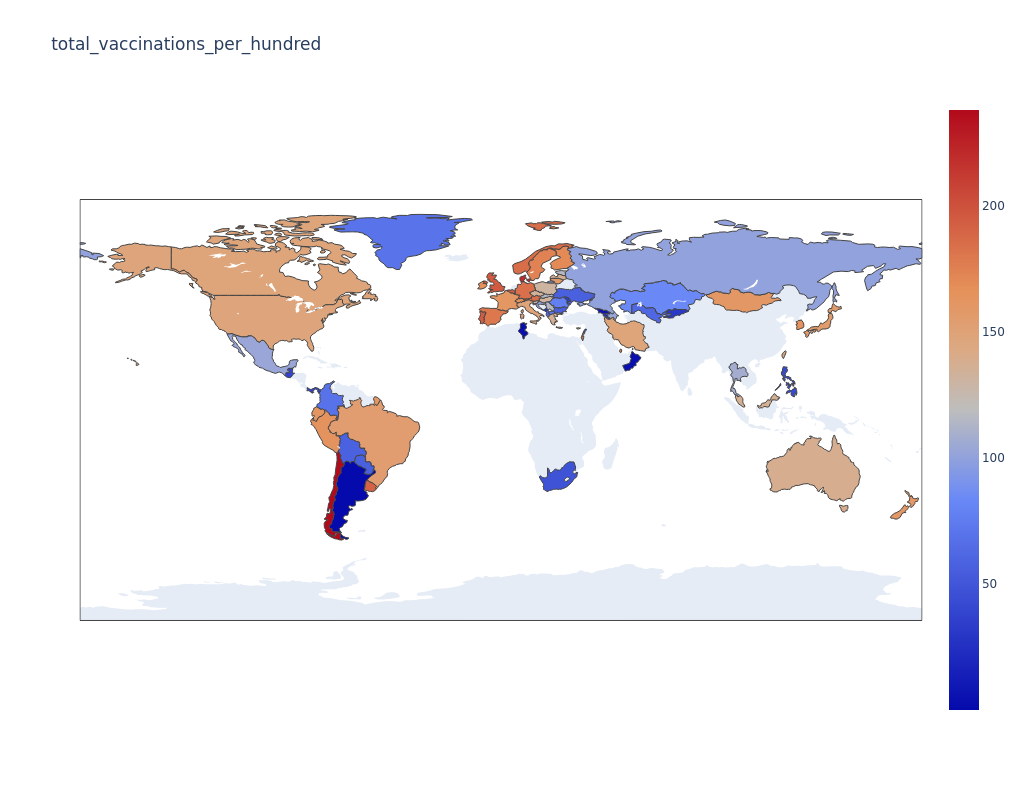

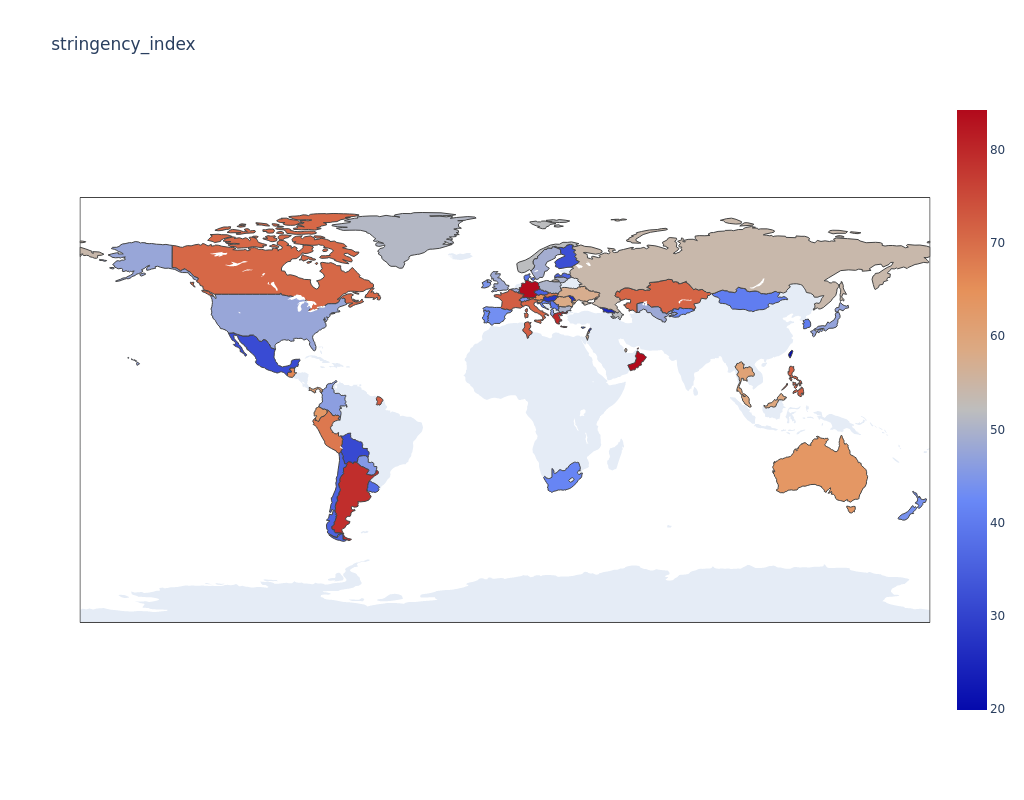

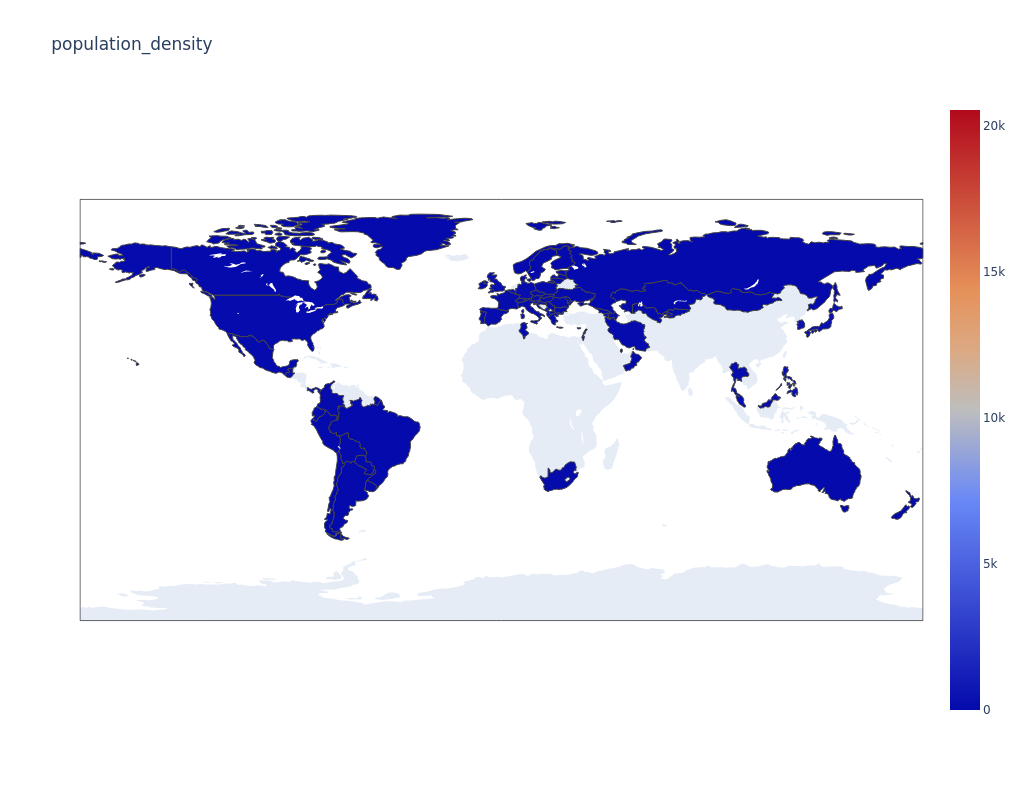

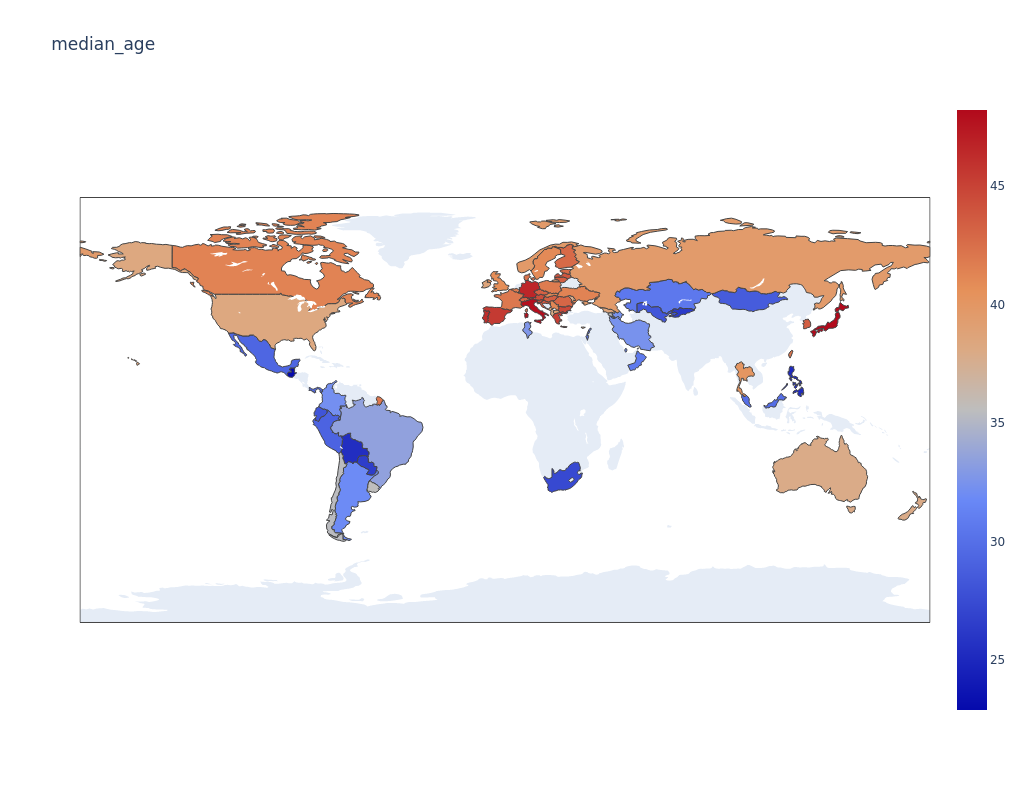

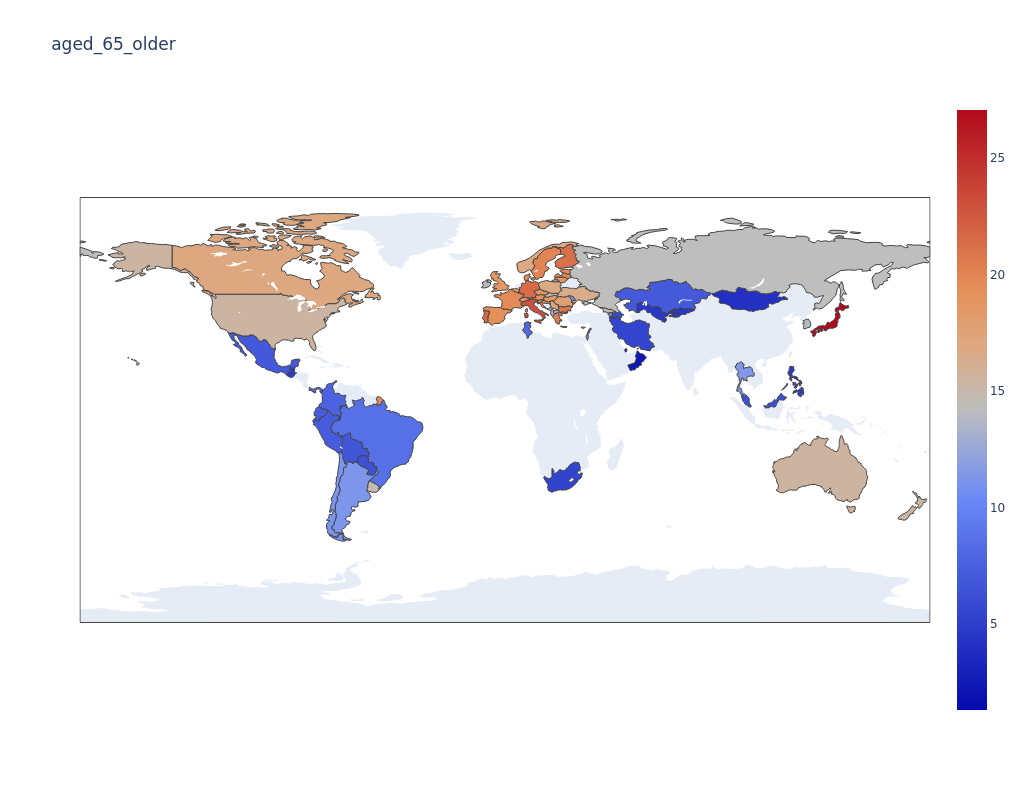

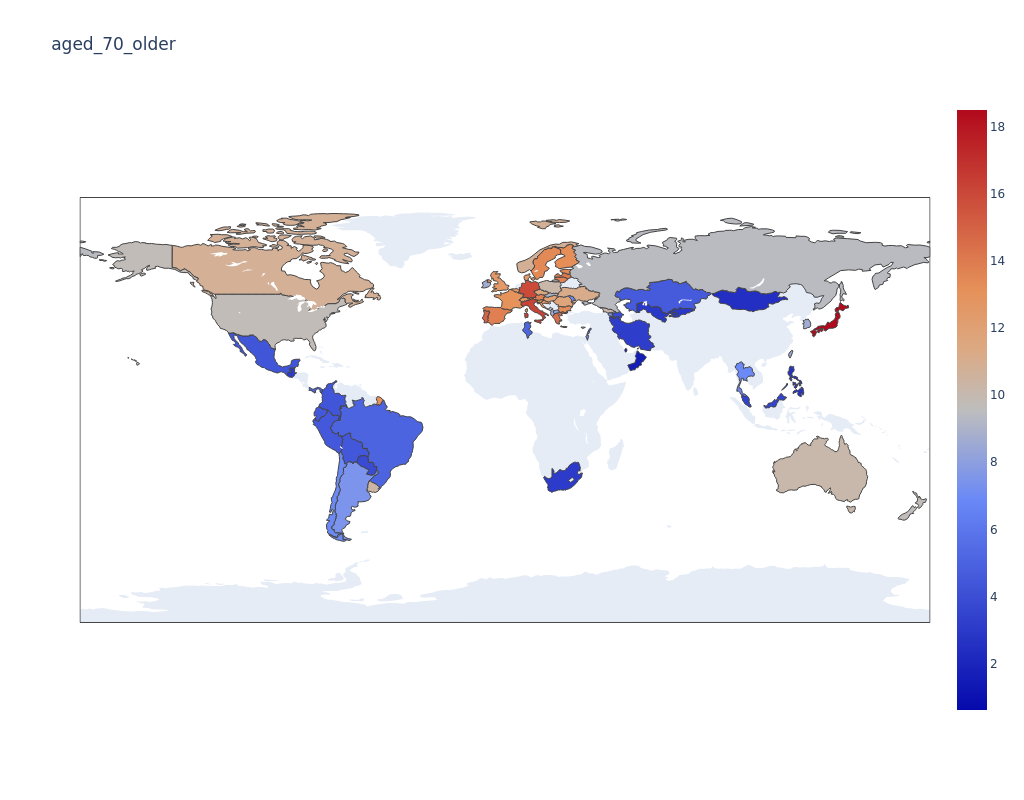

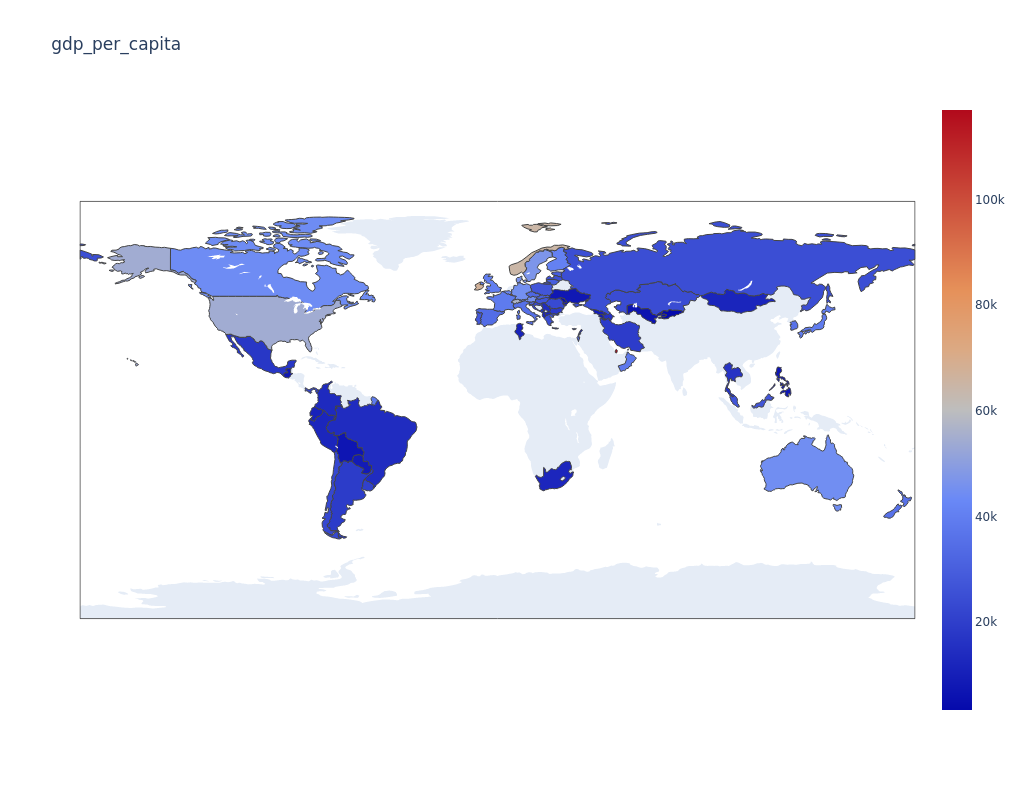

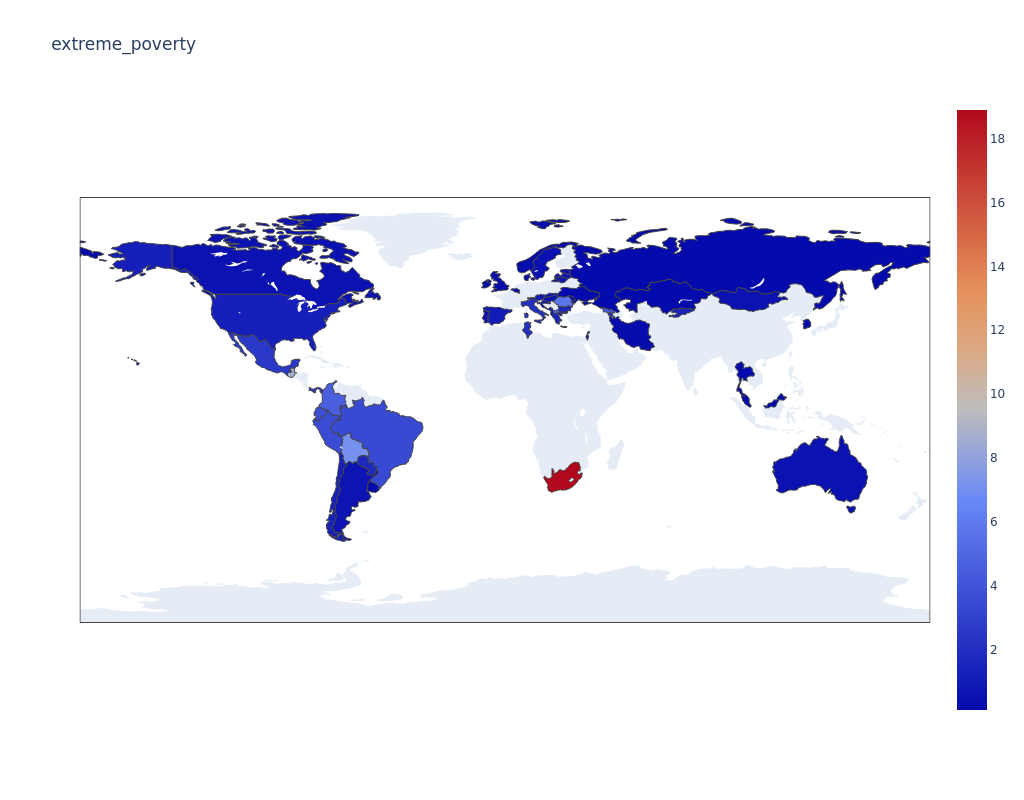

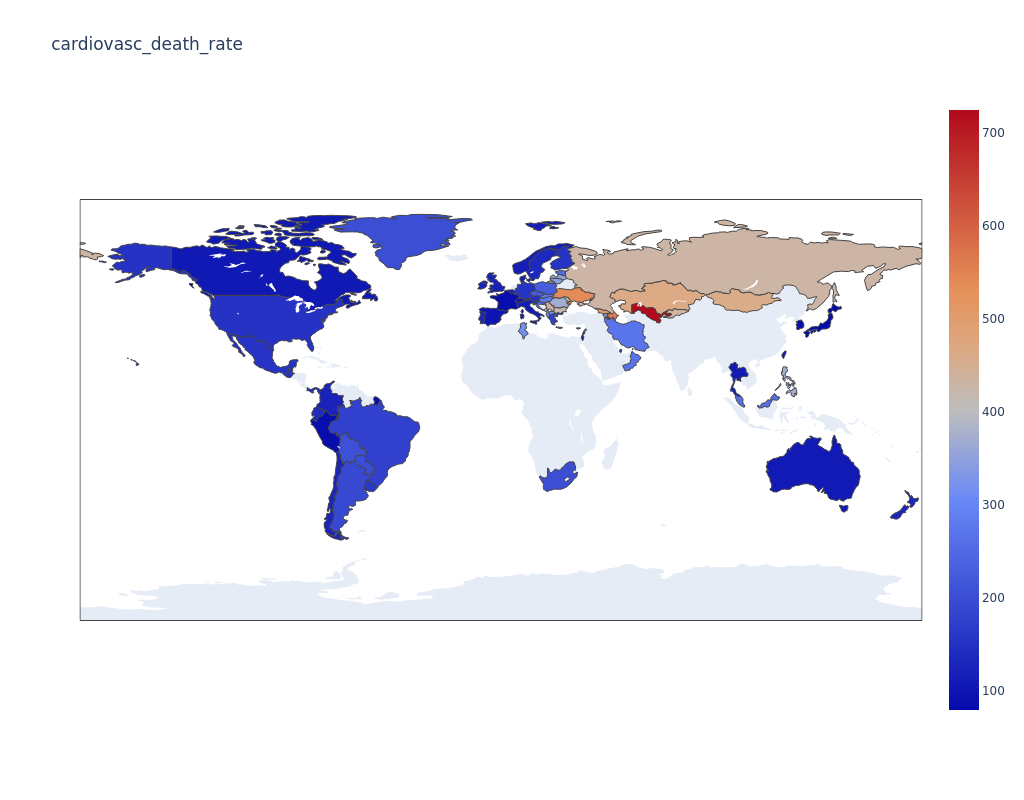

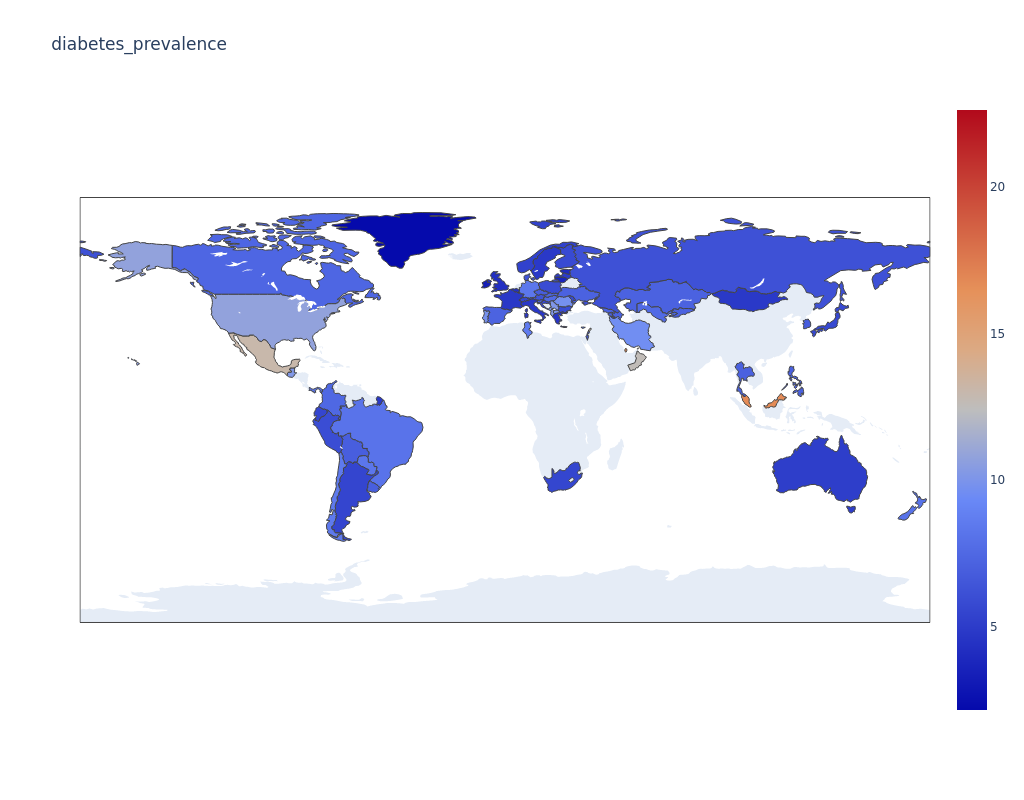

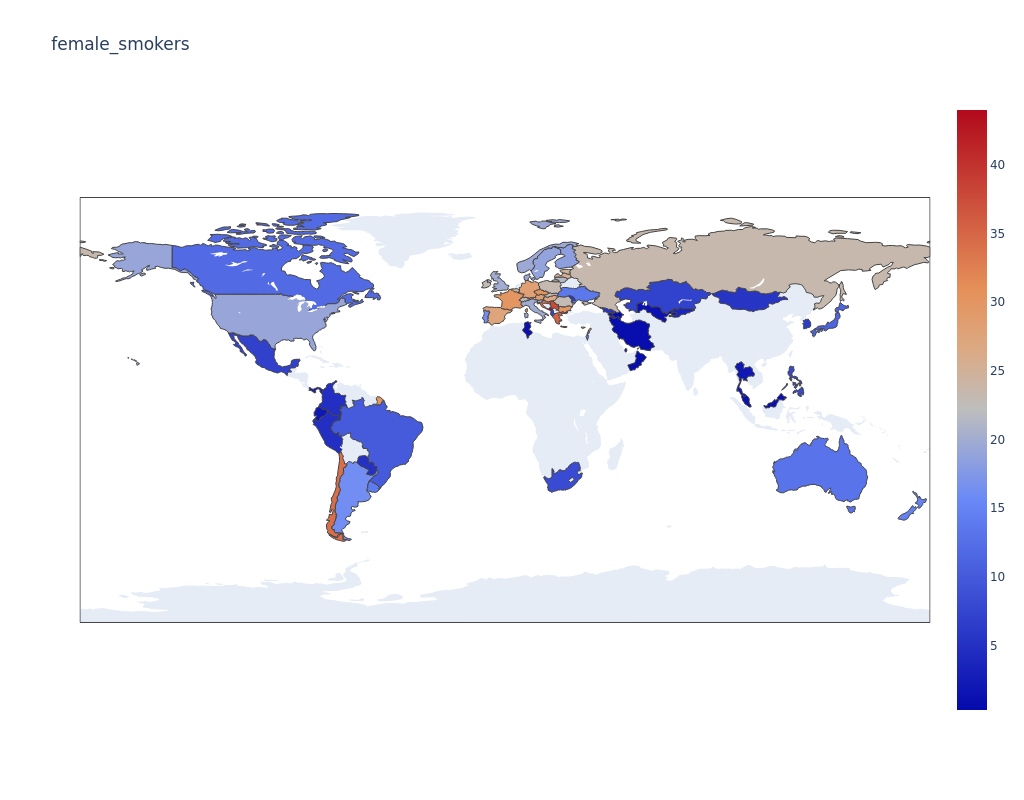

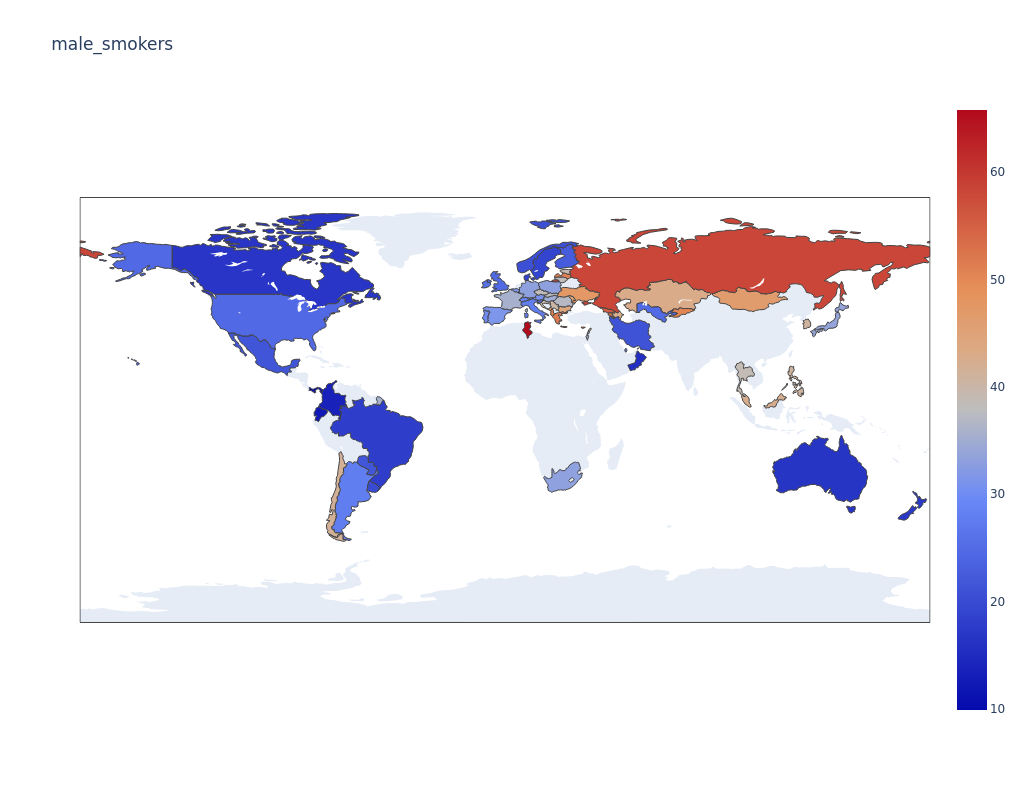

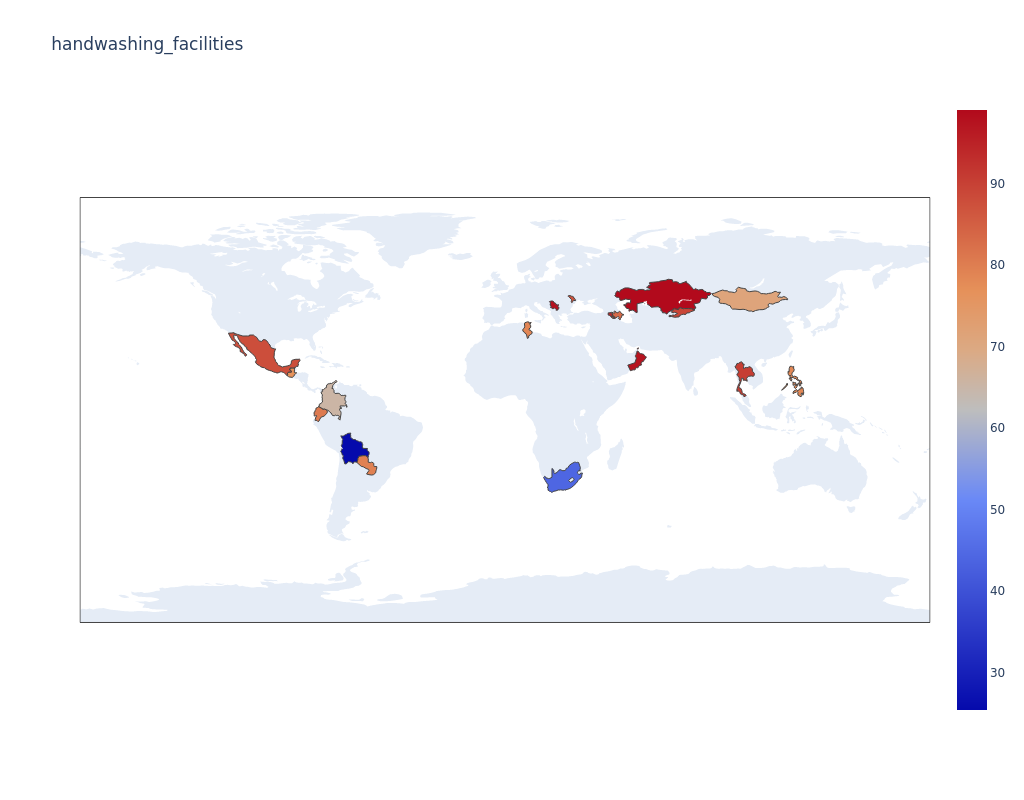

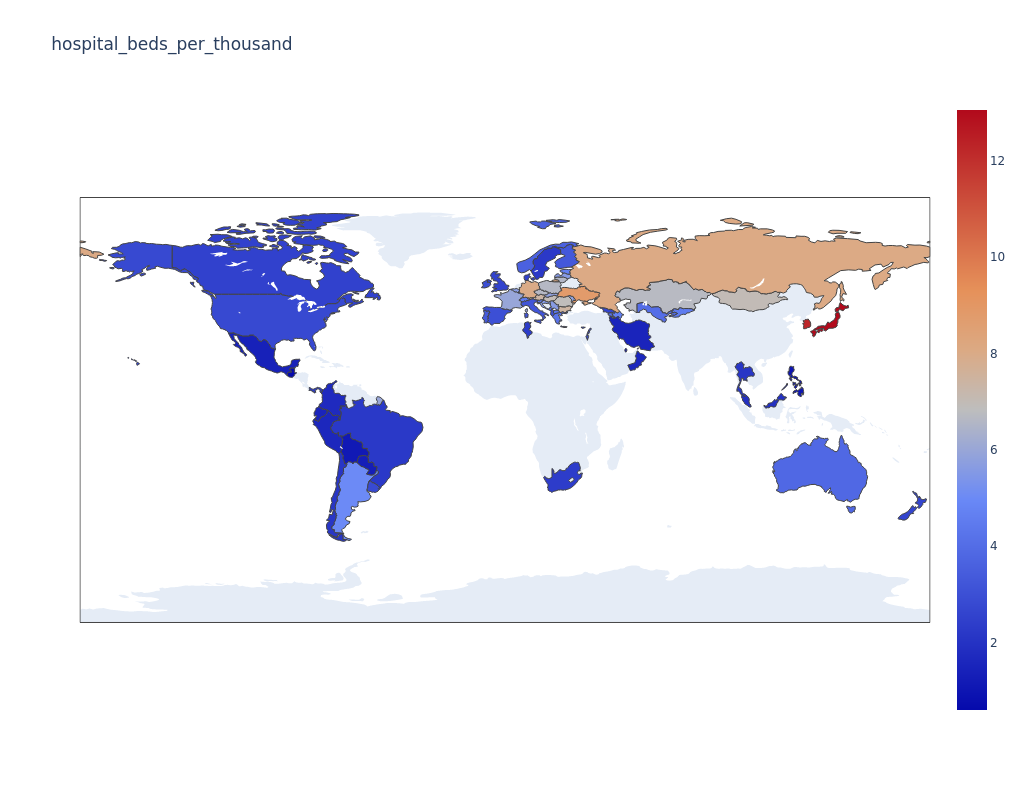

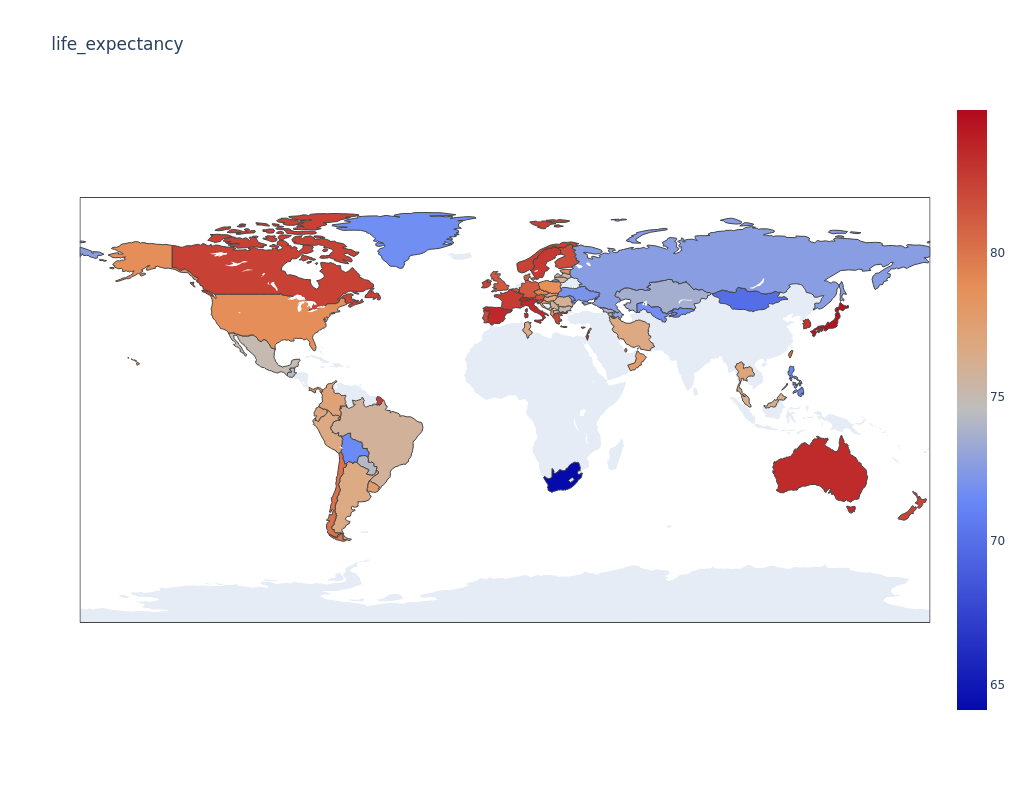

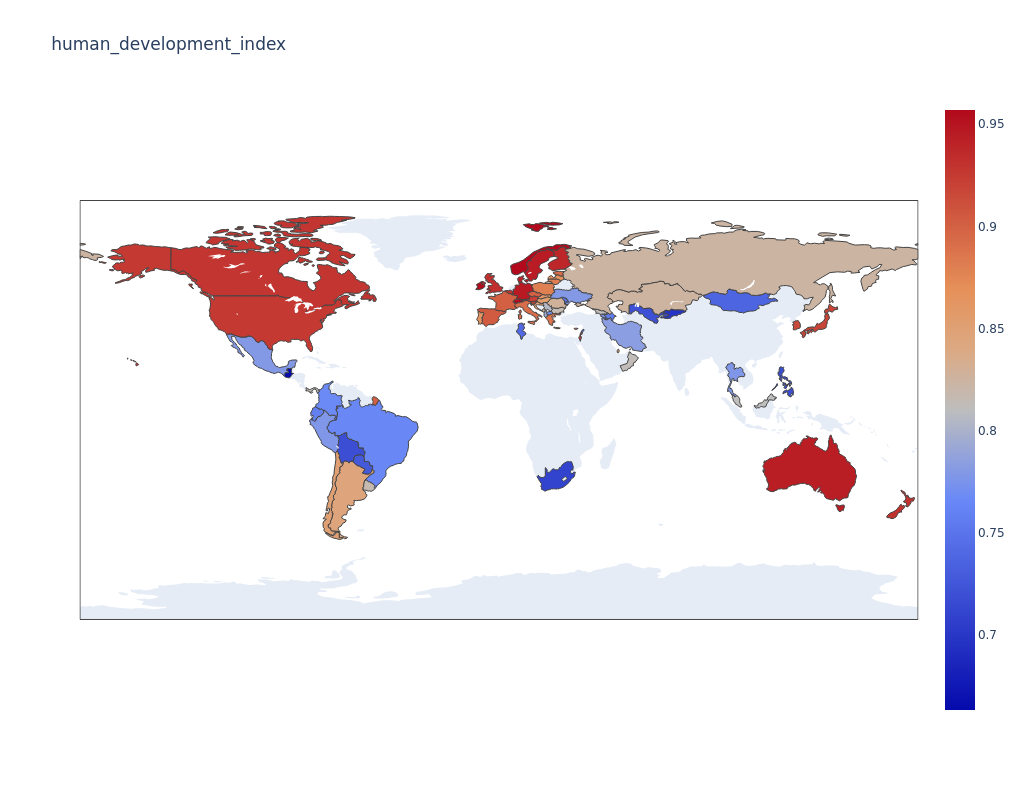

In [10]:
for metric in ['excess_mortality_cumulative_per_million','total_vaccinations_per_hundred','stringency_index',
       'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index',]:
    fig = go.Figure(data=go.Choropleth(
        locationmode = 'ISO-3',
        locations = df_latest['iso_code'],
        z = df_latest[metric],
        autocolorscale=False,
        #showscale=False
    ))
    fig.update_layout(
        width=1024,
        height=800,
        title_text=metric,
        geo=dict(
            showcoastlines=False,
        ),
        )
    fig.show('png')

gdp_per_capita = 0.28
stringency_index = 0.14
extreme_poverty = 0.11
hospital_beds_per_thousand = 0.10
life_expectancy = 0.09
diabetes_prevalence = 0.09
total_vaccinations_per_hundred = 0.05
handwashing_facilities = 0.04
aged_70_older = 0.04
population_density = 0.04
male_smokers = 0.02
median_age = 0.01
human_development_index = 0.00
aged_65_older = 0.00
cardiovasc_death_rate = 0.00
female_smokers = 0.00


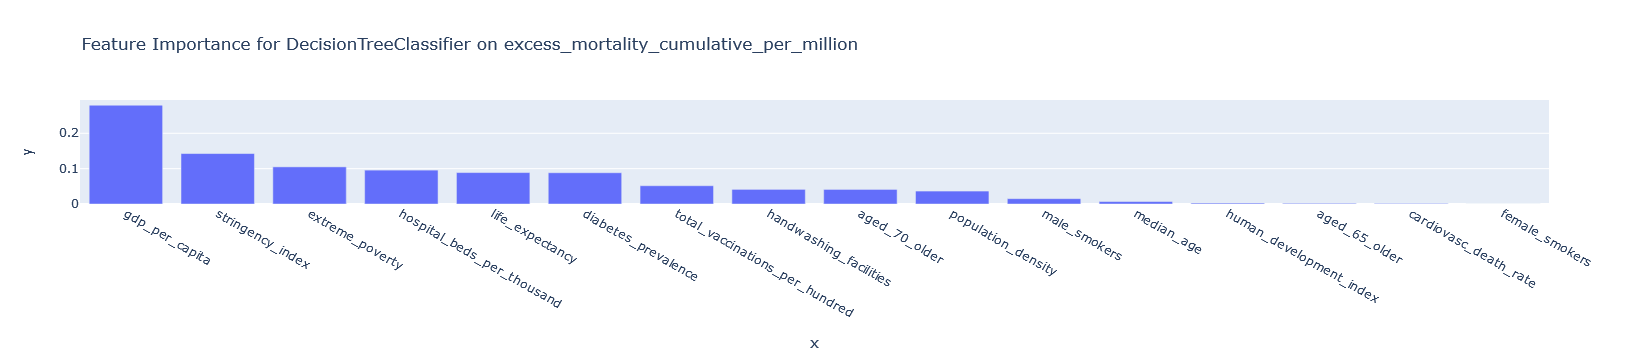

In [11]:
# decision tree for feature importance on a regression problem
from sklearn.tree import DecisionTreeRegressor
variables=['total_vaccinations_per_hundred', 'stringency_index',
       'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index',]
X = df_latest[variables].fillna(df_latest.mean()).values
y = df_latest['excess_mortality_cumulative_per_million'].values
model = DecisionTreeRegressor(random_state=42)
model.fit(X, y)
features_dict=dict(zip(variables, model.feature_importances_))
#sorted by value descending
sorted_features_dict=dict(sorted(features_dict.items(), key=lambda item: -item[1]))
for k, v in sorted_features_dict.items():
    print(f'{k} = {v:1.2f}')
fig=px.bar(x=sorted_features_dict.keys(), 
           y=sorted_features_dict.values(),
           title='Feature Importance for DecisionTreeClassifier on excess_mortality_cumulative_per_million'
          )
fig.show()

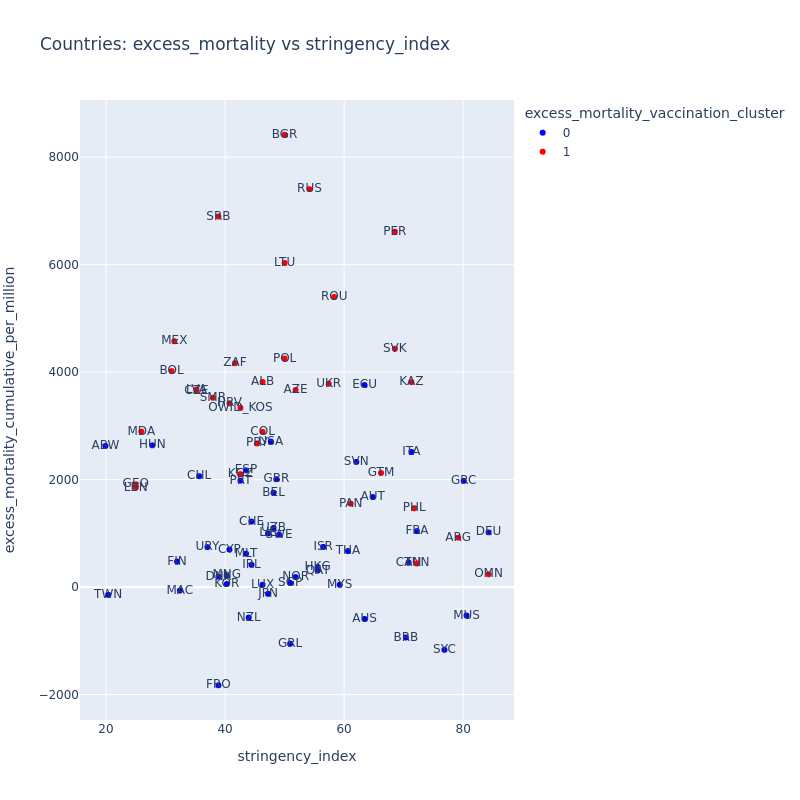

In [12]:
fig = px.scatter(df_latest,    
              x='stringency_index',
              y='excess_mortality_cumulative_per_million',
              color='excess_mortality_vaccination_cluster',
              color_discrete_sequence=['blue','red'],
              #size='population',
              text='iso_code',
              width=800,
              height=800,
              title='Countries: excess_mortality vs stringency_index'
             )
fig.show('png')

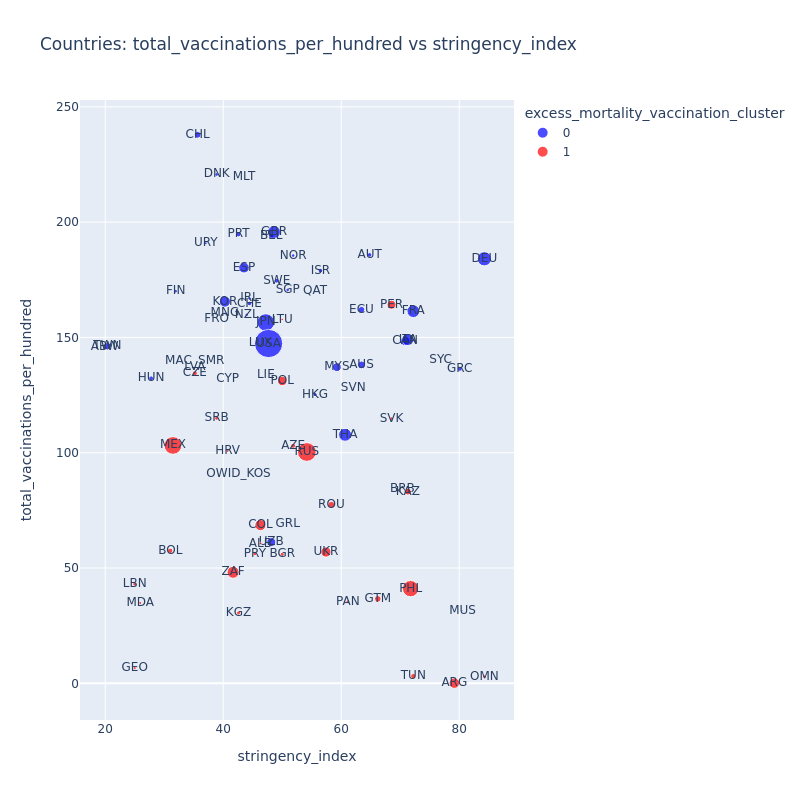

In [13]:
fig = px.scatter(df_latest,    
              x='stringency_index',
              y='total_vaccinations_per_hundred',
              color='excess_mortality_vaccination_cluster',
              color_discrete_sequence=['blue','red'],
              size='population',
              text='iso_code',
              width=800,
              height=800,
              title='Countries: total_vaccinations_per_hundred vs stringency_index'
             )
fig.show('png')

life_expectancy = 0.49
stringency_index = 0.13
gdp_per_capita = 0.12
extreme_poverty = 0.07
male_smokers = 0.06
median_age = 0.03
hospital_beds_per_thousand = 0.03
aged_70_older = 0.02
diabetes_prevalence = 0.02
population_density = 0.01
cardiovasc_death_rate = 0.00
human_development_index = 0.00
aged_65_older = 0.00
female_smokers = 0.00
handwashing_facilities = 0.00


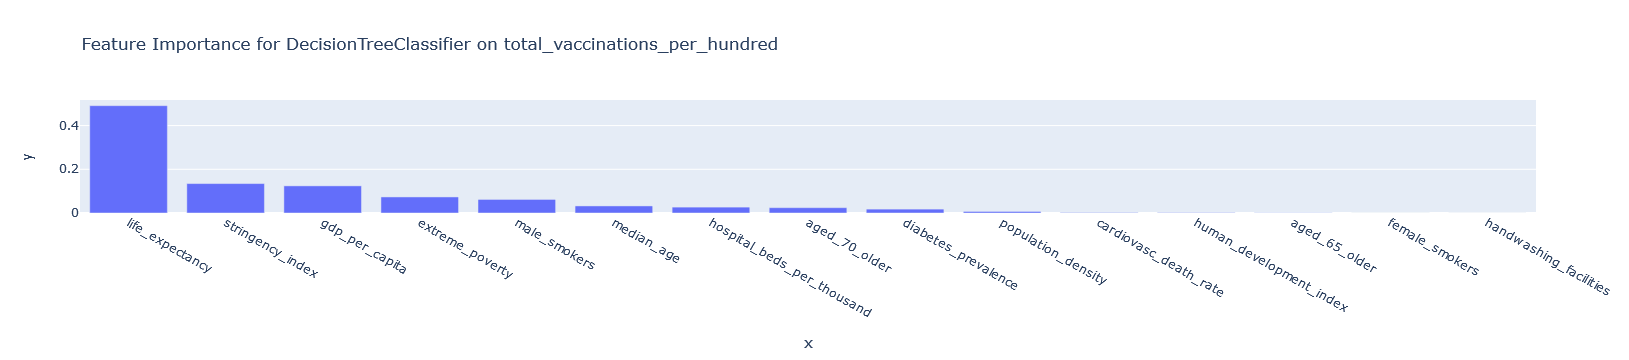

In [14]:
# decision tree for feature importance on a regression problem
from sklearn.tree import DecisionTreeRegressor
variables=[ 'stringency_index',
       'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index',]
X = df_latest[variables].fillna(df_latest.mean()).values
y = df_latest['total_vaccinations_per_hundred'].values
model = DecisionTreeRegressor(random_state=42)
model.fit(X, y)
features_dict=dict(zip(variables, model.feature_importances_))
#sorted by value descending
sorted_features_dict=dict(sorted(features_dict.items(), key=lambda item: -item[1]))
for k, v in sorted_features_dict.items():
    print(f'{k} = {v:1.2f}')
fig=px.bar(x=sorted_features_dict.keys(), 
           y=sorted_features_dict.values(),
           title='Feature Importance for DecisionTreeClassifier on total_vaccinations_per_hundred'
          )
fig.show()

## Let's add vaccine types

In [15]:
v=pd.read_csv('https://github.com/owid/covid-19-data/raw/master/public/data/vaccinations/locations.csv', sep=',', quotechar='"'
              , header=0, usecols=['iso_code', 'vaccines'], dtype={'iso_code':'str','vaccines':'str'} )

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer 
# convert to contain lists instead of plain text 
# TODO: get rid of leading spaces or whatever blanks they are instead of dropping all spaces.
v['vaccines']=v['vaccines'].str.replace(r'[^a-zA-Z,]+',r'').str.split(',') 

In [17]:
# break into indicator variables 
mlb = MultiLabelBinarizer() 
indicators = pd.DataFrame(mlb.fit_transform(v['vaccines']), 
                          columns=mlb.classes_, index=v.index)
vac_list=list(mlb.classes_)
vac_list

['Abdala',
 'COVIranBarekat',
 'CanSino',
 'Covaxin',
 'EpiVacCorona',
 'JohnsonJohnson',
 'Medigen',
 'Moderna',
 'Novavax',
 'OxfordAstraZeneca',
 'PfizerBioNTech',
 'QazVac',
 'SinopharmBeijing',
 'SinopharmWuhan',
 'Sinovac',
 'Soberana',
 'SputnikLight',
 'SputnikV',
 'Turkovac',
 'ZF']

In [18]:
v = pd.concat([v.reset_index(drop=True), 
                indicators.reset_index(drop=True)], axis=1) 
v

iso_code                                           vaccines  Abdala  \
0         AFG  [JohnsonJohnson, OxfordAstraZeneca, PfizerBioN...       0   
1         ALB  [OxfordAstraZeneca, PfizerBioNTech, Sinovac, S...       0   
2         DZA  [OxfordAstraZeneca, SinopharmBeijing, Sinovac,...       0   
3         AND       [Moderna, OxfordAstraZeneca, PfizerBioNTech]       0   
4         AGO                                [OxfordAstraZeneca]       0   
..        ...                                                ...     ...   
218  OWID_WLS       [Moderna, OxfordAstraZeneca, PfizerBioNTech]       0   
219       WLF                                          [Moderna]       0   
220       YEM       [JohnsonJohnson, OxfordAstraZeneca, Sinovac]       0   
221       ZMB  [JohnsonJohnson, OxfordAstraZeneca, SinopharmB...       0   
222       ZWE  [OxfordAstraZeneca, SinopharmBeijing, Sinovac,...       0   

     COVIranBarekat  CanSino  Covaxin  EpiVacCorona  JohnsonJohnson  Medigen  \
0                 0        0        0             0               1        0   
1                 0        0        0             0               0        0   
2                 0        0        0             0               0        0   
3                 0        0        0             0               0        0   
4                 0        0        0             0               0        0   
..              ...      ...      ...           ...             ...      ...   
218               0        0        0             0               0        0   
219               0        0        0             0               0        0   
220               0        0        0             0               1        0   
221               0        0        0             0               1        0   
222               0        0        0             0               0        0   

     Moderna  ...  PfizerBioNTech  QazVac  SinopharmBeijing  SinopharmWuhan  \
0          0  ...               1       0                 1               0   
1          0  ...               1       0                 0               0   
2          0  ...               0       0                 1               0   
3          1  ...               1       0                 0               0   
4          0  ...               0       0                 0               0   
..       ...  ...             ...     ...               ...             ...   
218        1  ...               1       0                 0               0   
219        1  ...               0       0                 0               0   
220        0  ...               0       0                 0               0   
221        0  ...               0       0                 1               0   
222        0  ...               0       0                 1               0   

     Sinovac  Soberana  SputnikLight  SputnikV  Turkovac  ZF  
0          0         0             0         0         0   0  
1          1         0             0         1         0   0  
2          1         0             0         1         0   0  
3          0         0             0         0         0   0  
4          0         0             0         0         0   0  
..       ...       ...           ...       ...       ...  ..  
218        0         0             0         0         0   0  
219        0         0             0         0         0   0  
220        1         0             0         0         0   0  
221        0         0             0         0         0   0  
222        1         0             0         1         0   0  

[223 rows x 22 columns]

In [19]:
v.set_index('iso_code', drop=True, inplace=True)

df_latest.set_index('iso_code', drop=False, inplace=True)

df_latest=df_latest.join(v, how='inner') 

## decision tree for feature importance on a classification problem

life_expectancy = 0.51
median_age = 0.13
cardiovasc_death_rate = 0.10
aged_65_older = 0.09
female_smokers = 0.05
SputnikV = 0.05
stringency_index = 0.05
population_density = 0.03
aged_70_older = 0.00
gdp_per_capita = 0.00
extreme_poverty = 0.00
diabetes_prevalence = 0.00
male_smokers = 0.00
handwashing_facilities = 0.00
hospital_beds_per_thousand = 0.00
human_development_index = 0.00
Abdala = 0.00
COVIranBarekat = 0.00
CanSino = 0.00
Covaxin = 0.00
EpiVacCorona = 0.00
JohnsonJohnson = 0.00
Medigen = 0.00
Moderna = 0.00
Novavax = 0.00
OxfordAstraZeneca = 0.00
PfizerBioNTech = 0.00
QazVac = 0.00
SinopharmBeijing = 0.00
SinopharmWuhan = 0.00
Sinovac = 0.00
Soberana = 0.00
SputnikLight = 0.00
Turkovac = 0.00
ZF = 0.00


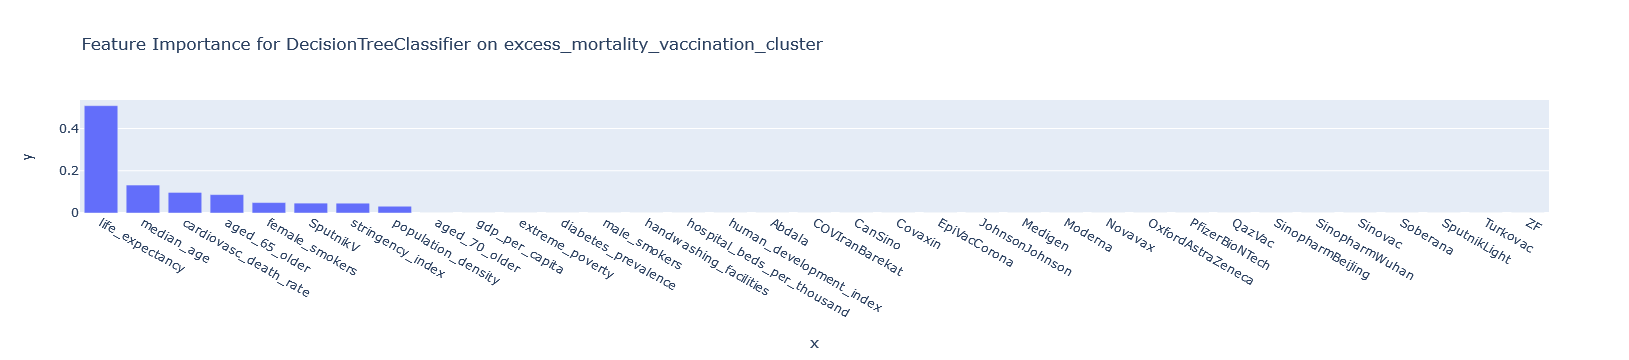

In [20]:
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeClassifier
variables=['stringency_index',
       'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index',]
variables.extend(vac_list)
X = df_latest[variables].fillna(df_latest.mean()).values
y = df_latest['excess_mortality_vaccination_cluster'].values
model = DecisionTreeClassifier(random_state=42)
model.fit(X, y)
features_dict=dict(zip(variables, model.feature_importances_))
#sorted by value descending
sorted_features_dict=dict(sorted(features_dict.items(), key=lambda item: -item[1]))
for k, v in sorted_features_dict.items():
    print(f'{k} = {v:1.2f}')
fig=px.bar(x=sorted_features_dict.keys(), 
           y=sorted_features_dict.values(),
           title='Feature Importance for DecisionTreeClassifier on excess_mortality_vaccination_cluster'
          )
fig.show()

## Decision tree for feature importance on a regression problem

gdp_per_capita = 0.27
stringency_index = 0.14
hospital_beds_per_thousand = 0.12
extreme_poverty = 0.09
diabetes_prevalence = 0.05
total_vaccinations_per_hundred = 0.05
life_expectancy = 0.04
population_density = 0.04
handwashing_facilities = 0.04
SinopharmBeijing = 0.04
female_smokers = 0.03
aged_70_older = 0.03
Sinovac = 0.02
male_smokers = 0.01
QazVac = 0.01
cardiovasc_death_rate = 0.01
median_age = 0.00
aged_65_older = 0.00
human_development_index = 0.00
PfizerBioNTech = 0.00
OxfordAstraZeneca = 0.00
Abdala = 0.00
COVIranBarekat = 0.00
CanSino = 0.00
Covaxin = 0.00
EpiVacCorona = 0.00
JohnsonJohnson = 0.00
Medigen = 0.00
Moderna = 0.00
Novavax = 0.00
SinopharmWuhan = 0.00
Soberana = 0.00
SputnikLight = 0.00
SputnikV = 0.00
Turkovac = 0.00
ZF = 0.00


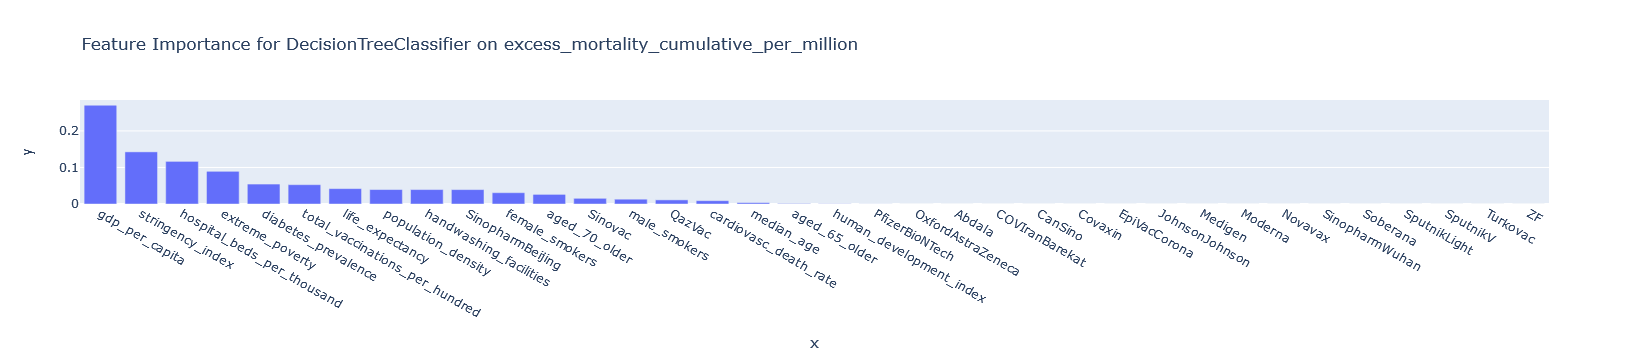

In [21]:
from sklearn.tree import DecisionTreeRegressor
variables=['total_vaccinations_per_hundred', 'stringency_index',
       'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index',]
variables.extend(vac_list)
X = df_latest[variables].fillna(df_latest.mean()).values
y = df_latest['excess_mortality_cumulative_per_million'].values
model = DecisionTreeRegressor(random_state=42)
model.fit(X, y)
features_dict=dict(zip(variables, model.feature_importances_))
#sorted by value descending
sorted_features_dict=dict(sorted(features_dict.items(), key=lambda item: -item[1]))
for k, v in sorted_features_dict.items():
    print(f'{k} = {v:1.2f}')
fig=px.bar(x=sorted_features_dict.keys(), 
           y=sorted_features_dict.values(),
           title='Feature Importance for DecisionTreeClassifier on excess_mortality_cumulative_per_million'
          )
fig.show()

# Further exploration of linear model
Robust Linear Model to see where we get with life_expectancy and female_smokers as confounding variables

                                       OLS Regression Results                                      
Dep. Variable:     excess_mortality_cumulative_per_million   R-squared:                       0.360
Model:                                                 OLS   Adj. R-squared:                  0.332
Method:                                      Least Squares   F-statistic:                     12.74
Date:                                     Sat, 29 Jan 2022   Prob (F-statistic):           1.06e-06
Time:                                             21:43:58   Log-Likelihood:                -635.51
No. Observations:                                       72   AIC:                             1279.
Df Residuals:                                           68   BIC:                             1288.
Df Model:                                                3                                         
Covariance Type:                                 nonrobust                                         


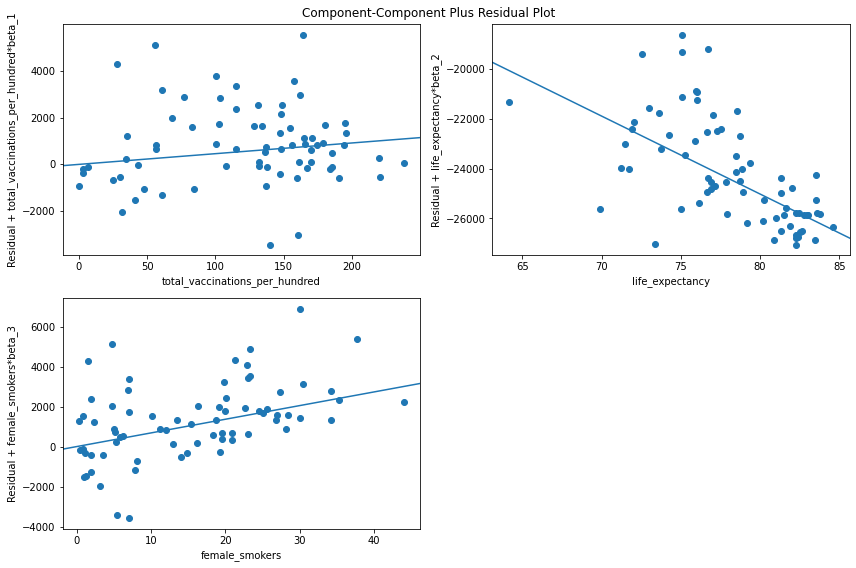

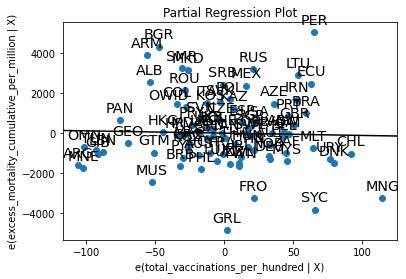

In [27]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import rlm
target='excess_mortality_cumulative_per_million'
independent='total_vaccinations_per_hundred'
confounding=['life_expectancy', 'female_smokers',]
model_string=target+'~'+independent+'+'+'+'.join(confounding)

model_ols = ols(model_string, data=df_latest, ).fit()
print(model_ols.summary())
model = rlm(model_string, data=df_latest, 
           M=sm.robust.norms.TukeyBiweight(3),).fit(conv="weights")
print(model.summary())

fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_ccpr_grid(model, fig=fig)

fig = sm.graphics.plot_partregress(
    target
    ,independent
    ,confounding , data=df_latest.fillna(df_latest.mean()))
#fig = sm.graphics.plot_leverage_resid2(model)
#fig = sm.graphics.influence_plot(model, size=4)


